In [1]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

class DeepQNetwork(nn.Module):
    """
    For a given observation, compute Q values for each action
        Attributes
    ----------
    lr: float
        learning rate
    input_dims : list
        [8]
    fc1_dims : int
        fully-connected layer 1
    fc2_dims : int
        fully-connected layer 2
    n_actions : int
        the number of actions
    """
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, n_actions, weight_decay=1e-5, p=0.1):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)
        self.dropout = nn.Dropout(p) 
        self.optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.loss = nn.MSELoss()
        self.loss = nn.SmoothL1Loss() # Huber loss
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)
    
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.dropout(x) # dropout for regularization
        actions = self.fc3(x)
        
        return actions

class Agent():
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions,
                max_mem_size=100000, eps_end=0.01, eps_dec=1e-5, weight_decay=1e-5):
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.action_space = [i for i in range(n_actions)] # list of actions
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0
        
        self.Q_eval = DeepQNetwork(self.lr, n_actions=n_actions, input_dims=input_dims, 
                                  fc1_dims=64, fc2_dims=64, weight_decay=weight_decay)
        
        self.state_memory = np.zeros((self.mem_size, *input_dims), dtype= np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)
        
    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size # residual. The memory is finite, so we are reusing
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] =  action
        self.terminal_memory[index] = done
        
        self.mem_cntr += 1
        
    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            state = T.tensor([observation]).to(self.Q_eval.device) # [] is used because of the nn library. torch.Size([1, 6])
            actions = self.Q_eval.forward(state)
            action = T.argmax(actions).item() # .item() to get integer
        else:
            action = np.random.choice(self.action_space)
            
        return action
    
    def learn(self):
        if self.mem_cntr < self.batch_size:
            return

        self.Q_eval.train()
        self.Q_eval.optimizer.zero_grad()
        
        max_mem = min(self.mem_cntr, self.mem_size) 
        # select samples the number of self.batch_size out of max_mem 
        batch = np.random.choice(max_mem, self.batch_size, replace=False) # Don't select the same thing again
        # array slicing [0,1,2,...,self.batch_size-1]
        batch_index = np.arange(self.batch_size, dtype=np.int32) 
        
        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
        reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)
        
        action_batch = self.action_memory[batch]
        
        q_eval = self.Q_eval.forward(state_batch)[batch_index, action_batch]
        q_next = self.Q_eval.forward(new_state_batch)
        q_next[terminal_batch] = 0.0
                                                 
        q_target = reward_batch + self.gamma * T.max(q_next, dim=1)[0]
        
        loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
        loss.backward()
        T.nn.utils.clip_grad_norm_(self.Q_eval.parameters(), 1.0) # gradient clip
        self.Q_eval.optimizer.step()
        
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min
        

# Load Model

In [18]:
from env6 import TradingSPYEnv
import numpy as np
import os
import pandas as pd
env = TradingSPYEnv(init_invest=100.0, sma_len=[5,10,15,20,25],mode='test',train_test_split=0.5)
#num_states = len(env.reset())
num_states = env.reset(2250).shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.n
print("Size of Action Space ->  {}".format(num_actions))

# Path to saved files
state_dict_path = os.path.join(os.getcwd(),'test6.pth')
best_state_dict_path = os.path.join(os.getcwd(),'best6.pth')

agent = Agent(gamma=0.99, epsilon=0.0, batch_size=4096, n_actions=num_actions, eps_end=0.0, input_dims = [num_states], lr=0.0001,
              weight_decay=1e-5)

# Choose one of those files
agent.Q_eval.load_state_dict(T.load(state_dict_path))
#agent.Q_eval.load_state_dict(T.load(best_state_dict_path))

agent.Q_eval.eval() # test mode
rewards = []

score = 0.0
done = False
observation = env.reset(2250)
action_list = []
while not done:
    action = agent.choose_action(observation)
    action_list.append(action)
    observation_, reward, done, info = env.step(action)
    score += reward
    observation = observation_
    rewards.append(reward)


print('score %.2f' % score,
     'long_return %.2f ' % info['long_return']
     )


C:\Users\golde\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Size of State Space ->  200
Size of Action Space ->  3
score 83.59 long_return 3.45 


In [19]:
normalized_portfolio = env.features.portfolio_value / 100.0
portfolio = normalized_portfolio[normalized_portfolio > 0.0] 
spy = env.features.Close.loc[portfolio.index]
spy /= spy.iloc[0]
df = {'portfolio': portfolio.values, 'benchmark': spy.values, 'Date': env.features['Date'].loc[portfolio.index]}
df = pd.DataFrame(df)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)

<AxesSubplot:xlabel='Date'>

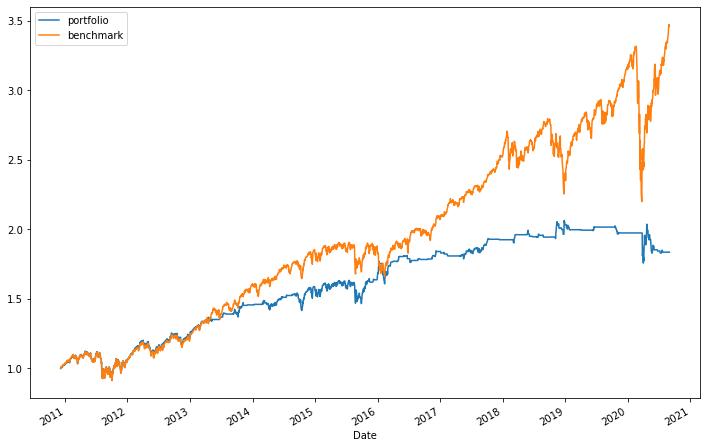

In [20]:
df.plot(figsize=(12,8))

<AxesSubplot:xlabel='Date'>

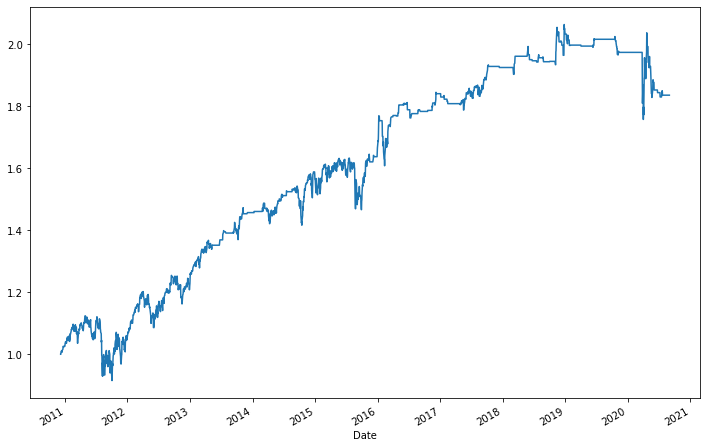

In [21]:
df['portfolio'].plot(figsize=(12,8))